<a href="https://colab.research.google.com/github/llayer/inferno/blob/master/inferno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replication of the 3D synthetic INFERNO example in TF 2.0

## 1. Statistical model

In [0]:
# For colab
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import itertools as it
from collections import OrderedDict
import numpy as np
import datetime, os

In [0]:
ds = tfp.distributions
k = tf.keras

In [0]:
import numpy as np

_MAXINT32 = 2**31 - 1

def truncate_seed(seed):
  return seed % _MAXINT32  # Truncate to fit into 32-bit integer


class IndependentList(ds.Distribution):
  """Independent distribution from a list of distributions.
  """

  def __init__(
      self, distributions,
      validate_args=False, name=None):
    """  Construct a `IndependentList` distribution.
    """
    parameters = locals()
    name = name or "IndependentList"
    self._distributions = distributions
    self._event_shapes = []
    for d in self._distributions:
        if len(d.event_shape) is 0:
          self._event_shapes.append(1)
        elif len(d.event_shape) is 1:
          self._event_shapes.append(d.event_shape.as_list()[0])
        else:
          raise ValueError(
              "Dimension of each distribution event_shape has to be 0 or 1")

    super(IndependentList, self).__init__(
        dtype=self._distributions[0].dtype,
        reparameterization_type=self._distributions[0].reparameterization_type,
        validate_args=validate_args,
        allow_nan_stats=self._distributions[0].allow_nan_stats,
        parameters=parameters,
        graph_parents=(
            sum([d._graph_parents for d in self._distributions],[])
        ),  # pylint: disable=protected-access
        name=name)

  @property
  def distributions(self):
    return self._distributions

  @property
  def event_shapes(self):
    return self._event_shapes

  def _batch_shape_tensor(self):
    batch_shape = self.distributions[0].batch_shape_tensor()
    return batch_shape

  def _batch_shape(self):
    batch_shape = self.distributions[0].batch_shape
    return batch_shape

  def _event_shape_tensor(self):
    event_shape = tf.convert_to_tensor([sum(self.event_shapes)], dtype=tf.float32)
    return event_shape

  def _event_shape(self):
    event_shape = tf.TensorShape([sum(self.event_shapes)])
    return event_shape

  def _sample_n(self, n, seed):
    rs = np.random.RandomState(seed=truncate_seed(seed))
    # get random seeds (have to be Python ints)
    seeds = rs.randint(low=0,high=10000, size=len(self.distributions))
    samples = [tf.reshape(d.sample(n, seed=seed),[n,-1])
               for s,d in zip(seeds,self.distributions)]
    return tf.concat(samples, axis=-1)

  def _log_prob(self, x):
    # beware caching in bijector composed distributions
    splitted_x = tf.split(x, self.event_shapes, axis=-1)
    log_probs = [tf.reshape(d.log_prob(x_i),
                   tf.concat([tf.shape(x_i)[:-1], [-1]], axis=-1))
                   for x_i, d in zip(splitted_x, self.distributions)]
    return tf.reduce_sum(tf.stack(log_probs, axis=-1), axis=-1)

In [0]:
r_dist = tf.Variable(2., shape=(), name="r_dist")
b_rate = tf.Variable(3., shape=(), name="b_rate")

In [0]:
# Background distribution with nuisance
# 2D normal  with variable mean
MultNormal = ds.MultivariateNormalTriL
# Initialize a single 3-variate Gaussian.
mu = [r_dist, 0.] #[2., 0.]
covariance_matrix=[[5., 0.], [0., 9.]]
scale = tf.linalg.cholesky(covariance_matrix)
b_01 = MultNormal(loc=mu, scale_tril=scale)

In [0]:
b_2 = ds.Exponential(rate = b_rate , name="b_2")

In [0]:
# Signal distribution
# 2D normal fully defined
s_01 = ds.MultivariateNormalDiag(loc=[0., 0.],
                                        scale_diag=[1., 1.], name="s_01")

In [0]:
s_2 = ds.Exponential(rate=2.0, name="s_2")

In [0]:
# full background distribution
b_dist = IndependentList(distributions=[b_01, b_2], name="b_dist")
s_dist = IndependentList(distributions=[s_01, s_2], name="s_dist")

In [0]:

# Full model
# expected amount of signal
s_exp = tf.Variable(50., shape=(), name="s_exp")
# expected amount of background
b_exp = tf.Variable(1000., shape=(), name="b_exp")

# compute signal fraction from s_exp and b_exp
mu = s_exp / (s_exp + b_exp)

# full mixture distribution
m_dist = ds.Mixture(cat=ds.Categorical(probs=[1. - mu, mu]),
                            components=[b_dist, s_dist],
                            name="mixture")

# ordered dict with all model parameters
all_pars = OrderedDict([('s_exp', s_exp),
                        ('r_dist', r_dist),
                        ('b_rate', b_rate),
                        ('b_exp', b_exp)])

## 2. Generate data

In [0]:
def generate_data(n_samples, seed):

    components = {"bkg": b_dist,
                    "sig": s_dist}

    dataset = {}
    for c_name, c_dist in components.items():
        dataset[c_name] = c_dist.sample(n_samples, seed=seed,
                                        name=f'{c_dist.name}_sample')

    return dataset

def train_data():

    return generate_data(n_samples=100000, seed=27)

def valid_data():

    return generate_data(n_samples=100000, seed=37)

def test_data():

    return generate_data(n_samples=500000, seed=47)

def log_density_ratio( x):

    log_dr = s_dist.log_prob(x) - b_dist.log_prob(x)

    return log_dr

def optimal_classifier( x):

    log_dr = log_density_ratio(x)
    opt_clf = tf.exp(log_dr) / (1. + tf.exp(log_dr))

    return opt_clf

In [0]:
train = train_data()
sig = tf.data.Dataset.from_tensor_slices(train['sig'])
bkg = tf.data.Dataset.from_tensor_slices(train['bkg'])

In [0]:
dataset = tf.data.Dataset.zip((sig, bkg))

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

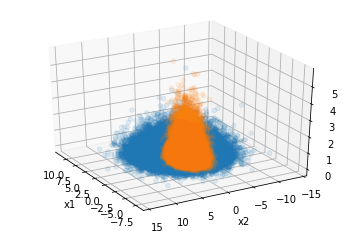

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
b = train['bkg'].numpy()
s = train['sig'].numpy()
ax.scatter(b[:,0], b[:,1], b[:,2], alpha=0.1)
ax.scatter(s[:,0], s[:,1], s[:,2], alpha=0.1)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.view_init(azim=150)



In [0]:

# Validation data
valid = valid_data()
sig_val = tf.data.Dataset.from_tensor_slices(valid['sig'])
bkg_val = tf.data.Dataset.from_tensor_slices(valid['bkg'])

In [0]:
val_set = tf.data.Dataset.zip((sig_val, bkg_val))

## 3. Train the model

In [0]:
k_init = "he_normal"
Dense = k.layers.Dense
par_names = ["s_exp", "r_dist", "b_rate"] #["s_exp"] #, "b_exp"] #["s_exp", "r_dist"]
poi = 's_exp'
pars = list(all_pars.values())
temperature = tf.Variable(0.1, shape=(), name="temp")
batch_size = 1000 #x2 for signal and bkg
aux = {"r_dist": ds.Normal(loc=2.0, scale=0.4),
       "b_rate": ds.Normal(loc=3.0, scale=1.)}
nn_model = k.Sequential([Dense(units=100, activation="relu",
                                    kernel_initializer=k_init,
                                    input_shape=(3,)),
                         Dense(units=100, activation="relu",
                                    kernel_initializer=k_init),
                              Dense(units=10, activation="linear")])
lr = 10e-5
optimizer = tf.keras.optimizers.Adam(lr)#, clipnorm=1)
#optimizer = tf.keras.optimizers.SGD(lr)#, clipnorm=1)

In [0]:
pars

[<tf.Variable 's_exp:0' shape=() dtype=float32, numpy=50.0>,
 <tf.Variable 'r_dist:0' shape=() dtype=float32, numpy=2.0>,
 <tf.Variable 'b_rate:0' shape=() dtype=float32, numpy=3.0>,
 <tf.Variable 'b_exp:0' shape=() dtype=float32, numpy=1000.0>]

In [0]:
nn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               400       
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
Total params: 11,510
Trainable params: 11,510
Non-trainable params: 0
_________________________________________________________________


In [0]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [0]:
batched_dataset = dataset.batch(batch_size)

In [0]:
@tf.function
def transform_bkg(x, r_dist_g=2., b_rate_g=3.):

    # apply transformations over each dim
    x_prime_0 = x[:, 0] - r_dist_g + r_dist
    x_prime_1 = x[:, 1]
    x_prime_2 = x[:, 2] * (b_rate_g / b_rate)

    x_prime = tf.stack([x_prime_0, x_prime_1, x_prime_2], 1,
                       name="x_prime")
    return x_prime

In [0]:
@tf.function
def cov_matrix(ext_nll, pars):

    pars = tuple(pars)

    indices = [list(all_pars.keys()).index(par) for par in pars]
    idx_subset = np.reshape(list(it.product(indices, indices)),
                            (len(pars), len(pars), -1))
    #print( idx_subset )

    hess_subset = tf.gather_nd(ext_nll, idx_subset)

    try:
        cov_nll = tf.linalg.inv(hess_subset)
    except:
        print( hess_subset )

    return cov_nll

In [0]:
@tf.function
def conv_hessian(grad_grad, par):

    grad_grad = [tf.zeros_like(pars[j]) if grad is None else grad
                        for j, grad in enumerate(grad_grad)]   
    grad_grad = [tf.expand_dims(g,1) if len(g.shape)==1 else g for g
                        in grad_grad]
    grad_shape = tf.concat([tf.shape(par),[len(pars)]], axis=0)

    return tf.reshape(tf.stack(grad_grad,axis=-1), grad_shape)

In [0]:
@tf.function
def get_counts(batch):

    logits = nn_model(batch)

    probs = tf.nn.softmax(logits / temperature)
    s_probs, b_probs = tf.split(probs, [batch_size,batch_size], axis=0)

    s_counts = tf.reduce_mean(s_probs, axis=0)
    b_counts = tf.reduce_mean(b_probs, axis=0)

    return s_counts, b_counts

In [0]:
@tf.function
def calculate_loss(s_batch, b_batch):

    with tf.GradientTape(persistent=True) as g:

        g.watch(s_exp)
        g.watch(b_exp)
        g.watch(r_dist)
        g.watch(b_rate)

        with tf.GradientTape(persistent=True) as gg:

            gg.watch(s_exp)
            gg.watch(b_exp)
            gg.watch(r_dist)
            gg.watch(b_rate)

            # Transfrom the background to include the nuisance parameters
            b_batch_trf = transform_bkg(b_batch)
            # Pass batch through the neural network to get the predictions for the counts
            train_batch = tf.concat([s_batch, b_batch_trf], axis=0, name="input_batch") 
            s_counts, b_counts = get_counts(train_batch)
            # Scale the predictions by the expected signal and background rates
            exp_counts = tf.cast(s_exp * s_counts + b_exp * b_counts, dtype=tf.float64)

            # Repeat the calculations with stopped gradients to get the asimov variable
            train_batch_const = tf.stop_gradient(train_batch)
            s_counts_asimov, b_counts_asimov = get_counts(train_batch_const)
            s_exp_asimov, b_exp_asimov = tf.stop_gradient(s_exp), tf.stop_gradient(b_exp)
            exp_counts_asimov = tf.cast(s_exp_asimov * s_counts_asimov + b_exp_asimov * b_counts_asimov, dtype=tf.float64)

            if verbose > 0:
                print("Counts")
                print(exp_counts)
                print("Asimov counts")
                print(exp_counts_asimov)

            # Log-likelihood
            pois = ds.Poisson(exp_counts, name="poisson")
            nll = - tf.cast(tf.reduce_sum(pois.log_prob(exp_counts_asimov)), name="nll", dtype=tf.float32)

            # Auxiliary measurements to constrain the nuisances
            nll_aux = {}
            for par, dist in aux.items():
                nll_aux[par] = -dist.log_prob(all_pars[par])
        
        # Gradient of the likelihood
        dy_dx = gg.gradient(nll, pars)
        dy_dx = [tf.zeros_like(pars[j]) if grad is None else grad for j, grad in enumerate(dy_dx)]  

        # Gradient of the auxiliary measurements
        dy_dx_aux = {}
        for par in nll_aux:
            dy_dx_aux_par = gg.gradient(nll_aux[par], pars)
            dy_dx_aux[par] = [tf.zeros_like(pars[j]) if grad is None else grad for j, grad in enumerate(dy_dx_aux_par)] 

    # Hessian of the likelihood
    hess_nll = []
    for i, grad in enumerate(dy_dx):
        grad_grad = g.gradient(grad, pars)
        hess_nll.append(conv_hessian(grad_grad, pars[i]))
    hess_nll = tf.stack(hess_nll, axis=-1)  

    if verbose > 0:
        print("Hessian nll")
        print( hess_nll ) 

    # Hessian of the auxiliary measurements
    hess_nll_aux = {}
    for par in dy_dx_aux:
        hess_nll_aux[par] = []
        for i, grad in enumerate(dy_dx_aux[par]):
            grad_grad = g.gradient(grad, pars)
            hess_nll_aux[par].append(conv_hessian(grad_grad, pars[i]))
        hess_nll_aux[par] = tf.stack(hess_nll_aux[par], axis=-1)  
        if verbose > 0:
            print("Hessian " + par)
            print(hess_nll_aux[par])

    # Extended likelihood
    ext_nll = sum([hess_nll] + list(hess_nll_aux.values()))

    # Covariance matrix
    cov_nll = cov_matrix(ext_nll, par_names)

    if verbose > 0:
        print("Extended likelihood")
        print(ext_nll)
        print("Covariance matrix")
        print(cov_nll)

    idx_poi = par_names.index(poi)
    loss = cov_nll[idx_poi, idx_poi] 

    return loss


In [0]:
verbose = 0
ibatch = 0

train_loss = []
val_loss = []

for epoch in range(100):

    # Check shuffle!! random seed!!
    dataset = dataset.shuffle(10000, reshuffle_each_iteration=True)
    batched_dataset = dataset.batch(batch_size)
    batched_valset = val_set.batch(batch_size)

    for s_batch, b_batch in batched_dataset:#.take(4):

        with tf.GradientTape() as tape:
            loss = calculate_loss(s_batch, b_batch)

        if verbose > 0:
            print("loss")
            print(loss)
        
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', loss, step = ibatch)

        gradients = tape.gradient(loss, nn_model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, nn_model.trainable_variables))

        ibatch += 1
    

    train_loss_epoch = []
    for s_batch, b_batch in batched_dataset:

        loss = calculate_loss(s_batch, b_batch)
        train_loss_epoch.append(loss)

    val_loss_epoch = []
    for s_batch, b_batch in batched_valset:
                
        loss = calculate_loss(s_batch, b_batch)
        val_loss_epoch.append(loss)

    train_loss.append(np.mean(train_loss_epoch))
    val_loss.append(np.mean(val_loss_epoch))

    print("Epoch: ", epoch)
    print("Train loss", train_loss[-1], " -- Val loss", val_loss[-1])

Epoch:  0
Train loss 652.04663  -- Val loss 628.47797
Epoch:  1
Train loss 595.3701  -- Val loss 592.2039
Epoch:  2
Train loss 544.62476  -- Val loss 523.93964
Epoch:  3
Train loss 488.56323  -- Val loss 485.1558
Epoch:  4
Train loss 458.59714  -- Val loss 457.9678
Epoch:  5
Train loss 449.43192  -- Val loss 443.18314
Epoch:  6
Train loss 436.61288  -- Val loss 428.28552
Epoch:  7
Train loss 426.90802  -- Val loss 416.12363
Epoch:  8
Train loss 421.38724  -- Val loss 407.95618
Epoch:  9
Train loss 416.33826  -- Val loss 403.90118
Epoch:  10
Train loss 402.10995  -- Val loss 393.0413
Epoch:  11
Train loss 390.81442  -- Val loss 383.99542
Epoch:  12
Train loss 381.9366  -- Val loss 375.28534
Epoch:  13
Train loss 368.79352  -- Val loss 358.9984
Epoch:  14
Train loss 364.19025  -- Val loss 356.59448
Epoch:  15
Train loss 353.0273  -- Val loss 345.74695
Epoch:  16
Train loss 350.59998  -- Val loss 339.2687
Epoch:  17
Train loss 341.69504  -- Val loss 334.74707
Epoch:  18
Train loss 339.916

Text(0, 0.5, 'std(s_exp)')

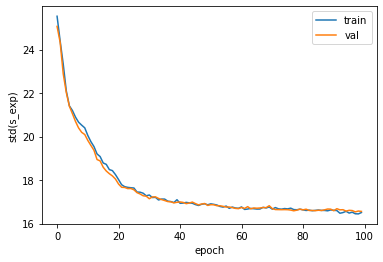

In [0]:
plt.plot(np.sqrt(train_loss))
plt.plot(np.sqrt(val_loss))
plt.legend(['train', 'val'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('std(s_exp)')

In [0]:
k.models.save_model( nn_model, 'model_sync.h5')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/model.h5"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
k.models.save_model( nn_model, path)

## Tensorboard 

In [0]:
%tensorboard --logdir logs/gradient_tape

## Predict shapes

In [0]:
model = k.models.load_model( 'model_sync.h5' )

In [0]:
model.summary()
# outputs
n_outputs = model.get_output_shape_at(0)[1]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               400       
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
Total params: 11,510
Trainable params: 11,510
Non-trainable params: 0
_________________________________________________________________


In [0]:
# predict signal
s_clf = model.predict(valid['sig'], batch_size=10000)

In [0]:
shapes = {}
# shape signal
shapes[("sig")] = np.bincount(np.argmax(s_clf, axis=-1), minlength=n_outputs)

In [0]:
default_par_scan = {'r_dist': [2.0, 2.2, 1.8],
                    'b_rate': [3.0, 3.5, 2.5]}
default_bins = np.linspace(0, 1, 11)

pars_scan=default_par_scan

In [0]:
for pars_val in it.product(*pars_scan.values()):

    b_vals_arr = transform_bkg(valid['bkg'], pars_val[0], pars_val[1])
    b_clf = model.predict(b_vals_arr, batch_size=10000)
    key = ("bkg_" + str(pars_val))
    b_clf_hist = np.bincount(np.argmax(b_clf, axis=-1), minlength=n_outputs)
    shapes[key] = b_clf_hist

In [0]:
shapes

{'sig': array([19386,   259,  2632,   532,   324,  9687, 12119,   483,   753,
        53825]),
 'bkg_(2.0, 3.0)': array([ 1351,   232,  5966,    68,    34, 50774, 31239,    88,    63,
        10185]),
 'bkg_(2.0, 3.5)': array([ 1744,   321,  7430,   126,    53, 48593, 31584,   137,   103,
         9909]),
 'bkg_(2.0, 2.5)': array([ 1011,   169,  4479,    36,    18, 53085, 30739,    51,    40,
        10372]),
 'bkg_(2.2, 3.0)': array([ 1508,   239,  5780,    74,    37, 47672, 33492,    83,    69,
        11046]),
 'bkg_(2.2, 3.5)': array([ 1904,   318,  7160,   140,    53, 45552, 33849,   154,   111,
        10759]),
 'bkg_(2.2, 2.5)': array([ 1104,   167,  4345,    34,    17, 49859, 33089,    50,    39,
        11296]),
 'bkg_(1.8, 3.0)': array([ 1227,   241,  6164,    66,    37, 53834, 28979,    88,    63,
         9301]),
 'bkg_(1.8, 3.5)': array([ 1566,   327,  7681,   113,    61, 51590, 29353,   126,   104,
         9079]),
 'bkg_(1.8, 2.5)': array([  918,   132,  4599,    44,    

## Templates


In [0]:
def normalise(arr):
    arr = np.array(arr, dtype=np.float32)
    return arr / arr.sum()

templates = {k: normalise(v) for k, v in shapes.items()}

In [0]:
def get_str(rd, br):
    return str( (pars_scan['r_dist'][rd], pars_scan['b_rate'][br]) )

In [0]:
sig_shape = templates[('sig')]
c_nom = templates['bkg_' + get_str(0,0)]
c_up = np.array([templates['bkg_' + get_str(1,0)], templates['bkg_' + get_str(0,1)]])
c_dw = np.array([templates['bkg_' + get_str(2,0)], templates['bkg_' + get_str(0,2)]])

In [0]:
zero_filter = np.all([(sig_shape != 0.), (c_nom != 0.)], axis=0)
templates = {k: v[zero_filter] for k, v in templates.items() if not ('pars' in k[0])}

In [0]:
c_nom = c_nom[zero_filter]
c_up = c_up[:, zero_filter]
c_dw = c_dw[:, zero_filter] 
sig_shape = sig_shape[zero_filter]

In [0]:
print( c_nom )
print( c_up )
print( c_dw )
print( sig_shape )

[1.3510e-02 2.3200e-03 5.9660e-02 6.8000e-04 3.4000e-04 5.0774e-01
 3.1239e-01 8.8000e-04 6.3000e-04 1.0185e-01]
[[1.5080e-02 2.3900e-03 5.7800e-02 7.4000e-04 3.7000e-04 4.7672e-01
  3.3492e-01 8.3000e-04 6.9000e-04 1.1046e-01]
 [1.7440e-02 3.2100e-03 7.4300e-02 1.2600e-03 5.3000e-04 4.8593e-01
  3.1584e-01 1.3700e-03 1.0300e-03 9.9090e-02]]
[[1.2270e-02 2.4100e-03 6.1640e-02 6.6000e-04 3.7000e-04 5.3834e-01
  2.8979e-01 8.8000e-04 6.3000e-04 9.3010e-02]
 [1.0110e-02 1.6900e-03 4.4790e-02 3.6000e-04 1.8000e-04 5.3085e-01
  3.0739e-01 5.1000e-04 4.0000e-04 1.0372e-01]]
[0.19386 0.00259 0.02632 0.00532 0.00324 0.09687 0.12119 0.00483 0.00753
 0.53825]


## Profile likelihood

In [0]:
rdist_shift = (max(pars_scan['r_dist']) - min(pars_scan['r_dist'])) / 2
brate_shift = (max(pars_scan['b_rate']) - min(pars_scan['b_rate'])) / 2
r_dist_init = pars_scan['r_dist'][0]
b_rate_init = pars_scan['b_rate'][0]

In [0]:
def int_quad_lin(alpha, c_nom, c_up, c_dw, multiple_pars=False):

    if multiple_pars:
        tiling_shape = [1, 1, 1, tf.shape(c_nom)[0]]
        expand_axis = 1
    else:
        tiling_shape = [1, 1, tf.shape(c_nom)[0]]
        expand_axis = 0

    
    # alpha dimensions are (1, n_par_types, n_par_inst)
    # c_dw and c_up are (n_bins, n_par_types)
    alpha_exp = tf.expand_dims(alpha, axis=-1)
    alpha_t = tf.tile(alpha_exp, tiling_shape)
    #alpha_t dimensions are (1, n_par_types, n_par_inst, n_bins)
    #print(alpha_t)
    # if multiple_pars is True or (1, n_par_types, n_bins)
    a = tf.expand_dims(0.5 * (c_up + c_dw) - c_nom, axis=expand_axis, name="a")
    b = tf.expand_dims(0.5 * (c_up - c_dw), axis=expand_axis, name="b")
    ones = tf.ones_like(alpha_t, dtype='float32')

    #print(alpha_t)
    #print(ones)
    #print(tf.expand_dims(c_dw - c_nom, axis=expand_axis))

    #up = ones * tf.expand_dims(c_dw - c_nom, axis=expand_axis)
    #dw = ones * tf.expand_dims(c_up - c_nom, axis=expand_axis)

    switch = tf.where(alpha_t < 0.,
                    ones * tf.expand_dims(c_dw - c_nom, axis=expand_axis),
                    ones * tf.expand_dims(c_up - c_nom, axis=expand_axis))
    
    
    #  (1, n_par_types, n_par_inst, n_bins) broadcast when multiple_pars
    #      (n_par_types,         1, n_bins) (if expand axis 1)
    #  (1, n_par_types, n_bins) broadcast when not multiple_pars
    #      (n_par_types,n_bins) (if expand axis 0)
    
    alpha_t = tf.cast(alpha_t, dtype=tf.float32)
    #print((2 * b + tf.sign(alpha_t) * a) * (alpha_t - tf.sign(alpha_t)) + switch)
    
    
    abs_var = tf.where(tf.abs(alpha_t) > 1.,
                        (2 * b + tf.sign(alpha_t) * a) *
                        (alpha_t - tf.sign(alpha_t)) + switch,
                        a * tf.pow(alpha_t, 2) + b * alpha_t)
    # abs_var is (1, n_par_types, n_par_inst, n_bins) or (1, n_par_types, n_bins)
    return c_nom + tf.reduce_sum(abs_var, axis=1)
    


In [0]:
def get_asimov():
    
    alpha_pars = [[(r_dist - r_dist_init) / rdist_shift,
                (b_rate - b_rate_init) / brate_shift]]
    #print(alpha_pars)

    # bkg_shape shape is (n_par_inst, n_bins, 1) if multiple_pars
    bkg_shape = int_quad_lin(alpha_pars, c_nom, c_up, c_dw, multiple_pars=False)

    print(c_nom)
    print(bkg_shape)
    
    s_exp_e = tf.cast(s_exp, dtype=tf.float32)
    b_exp_e = tf.cast(b_exp, dtype=tf.float32)

    sig_shape_e = tf.expand_dims(sig_shape, axis=0,
                                name="expanded_sig_shape")
    s_exp_e = tf.expand_dims(s_exp_e, axis=-1, name="expanded_s_exp")
    b_exp_e = tf.expand_dims(b_exp_e, axis=-1, name="expanded_b_exp")
    
    #print( sig_shape_exp)

    t_exp = tf.cast(s_exp_e * sig_shape +
                            b_exp_e * bkg_shape,
                            dtype=tf.float64, name="t_exp")
    
    return tf.stop_gradient(t_exp)


In [0]:
def calc_hesse(asimov, all_pars):
    
    pars = list(all_pars.values())
    with tf.GradientTape(persistent=True) as g:

        """
        g.watch(tm_s_exp)
        g.watch(tm_b_exp)
        g.watch(tm_r_dist)
        g.watch(tm_b_rate)
        """
        g.watch(pars)
        
        with tf.GradientTape(persistent=True) as gg:

            """
            gg.watch(tm_s_exp)
            gg.watch(tm_b_exp)
            gg.watch(tm_r_dist)
            gg.watch(tm_b_rate)
            """
            
            gg.watch(pars)
            
            alpha_pars = [[(all_pars['tm_r_dist'] - r_dist_init) / rdist_shift,
                            (all_pars['tm_b_rate'] - b_rate_init) / brate_shift]]

            # bkg_shape shape is (n_par_inst, n_bins, 1) if multiple_pars
            bkg_shape = int_quad_lin(alpha_pars, c_nom, c_up, c_dw, multiple_pars=True)

            tm_s_exp_e = tf.cast(all_pars['tm_s_exp'], dtype=tf.float32)
            tm_b_exp_e = tf.cast(all_pars['tm_b_exp'], dtype=tf.float32)

            sig_shape_e = tf.expand_dims(sig_shape, axis=0,
                                        name="expanded_sig_shape")
            s_exp_e = tf.expand_dims(tm_s_exp_e, axis=-1, name="expanded_s_exp")
            b_exp_e = tf.expand_dims(tm_b_exp_e, axis=-1, name="expanded_b_exp")

            #print( sig_shape_exp)

            t_exp = tf.cast(s_exp_e * sig_shape +
                                    b_exp_e * bkg_shape,
                                    dtype=tf.float64, name="t_exp")

            # Log-likelihood
            h_pois = ds.Poisson(t_exp)
            nll = - tf.cast(tf.reduce_sum(h_pois.log_prob(asimov), axis=-1),
                        dtype=tf.float32)
        
            #print(nll)
    
        # Gradient of the likelihood
        dy_dx = gg.gradient(nll, pars)
        dy_dx = [tf.zeros_like(pars[j]) if grad is None else grad for j, grad in enumerate(dy_dx)]  

        #print("GRADIENT")
        #print(dy_dx)
        
    
    # Hessian of the likelihood
    
    #print("HESSIAN")
    hess_nll = []
    for i, grad in enumerate(dy_dx):
        grad_grad = g.gradient(grad, pars)
    
    
        grad_grad = [tf.zeros_like(pars[j]) if grad is None else grad
                            for j, grad in enumerate(grad_grad)]   
        
        grad_grad = [tf.expand_dims(g,1) if len(g.shape)==1 else g for g
                            in grad_grad]
        
        
        grad_shape = tf.concat([tf.shape(pars[i]),[len(pars)]], axis=0)

        #print(grad_shape)
        
        grad_grad = tf.reshape(tf.stack(grad_grad,axis=-1), grad_shape)
        
        #print(grad_grad)
        
        hess_nll.append(grad_grad)
    hess_nll = tf.stack(hess_nll, axis=-1)  

    """
    if verbose > 0:
        print("Hessian nll")
        print( hess_nll ) 
    """

    # expand dimensions if scalar-dim parameter
    dy_dx = [tf.expand_dims(g,1) if len(g.shape)==1 else g for g in dy_dx]
    # reshape to deal with scalars
    dy_dx_shape = tf.concat([tf.shape(pars[0]),[len(pars)]],axis=0)
    dy_dx = tf.reshape(tf.stack(dy_dx,axis=-1), dy_dx_shape)
    
    
    return nll.numpy(), hess_nll.numpy(), dy_dx.numpy()

In [0]:
step_size = 0.1
n_steps = 100
d = 0.0
par_names = ["tm_r_dist","tm_b_rate"]
par_names = tuple(par_names)

s_exp_scan = np.linspace(20.,80.,60, endpoint=True)
tm_r_dist = tf.Variable( 2.0*np.ones_like(s_exp_scan) )
tm_b_rate = tf.Variable( 3.0*np.ones_like(s_exp_scan) )
tm_s_exp = tf.Variable( s_exp_scan )
tm_b_exp = tf.Variable( 1000.0*np.ones_like(s_exp_scan) )

all_pars = OrderedDict([('tm_s_exp', tm_s_exp),
                        ('tm_r_dist', tm_r_dist),
                        ('tm_b_rate', tm_b_rate),
                        ('tm_b_exp', tm_b_exp)])



asimov_data = get_asimov()[0]
nll, hesse, gradient = calc_hesse(asimov_data, all_pars)

""" FIXME hack to get the subpars
indices = [list(all_pars.keys()).index(par) for par in par_names]
idx_subset = np.reshape(list(it.product(indices, indices)),
                        (len(par_names), len(par_names), -1)).T
"""                        
sub_hess= hesse[:, 1:3, 1:3]
sub_grad = gradient[:, 1:3]

#print(sub_hess)

for i in range(n_steps):
    
    newton_step = np.matmul(np.linalg.inv(sub_hess + d * np.ones([len(par_names)])), sub_grad[:,:,np.newaxis])
    
    #print(newton_step)
    
    #tm_r_dist = tm_r_dist - step_size*newton_step[:,0,0]
    #tm_b_rate = tm_b_rate - step_size*newton_step[:,1,0]
    
    all_pars['tm_r_dist'] = tm_r_dist - step_size*newton_step[:,0,0] 
    all_pars['tm_b_rate'] = tm_b_rate - step_size*newton_step[:,1,0] 
    
    #print(all_pars)
    
    p_nll, hesse, gradient = calc_hesse(asimov_data, all_pars)
    #print(gradient)
    
    sub_hess = hesse[:, 1:3, 1:3]
    sub_grad = gradient[:, 1:3]
    
    print(p_nll)
    
    #print(all_pars)

[1.3510e-02 2.3200e-03 5.9660e-02 6.8000e-04 3.4000e-04 5.0774e-01
 3.1239e-01 8.8000e-04 6.3000e-04 1.0185e-01]
tf.Tensor(
[[1.3510e-02 2.3200e-03 5.9660e-02 6.8000e-04 3.4000e-04 5.0774e-01
  3.1239e-01 8.8000e-04 6.3000e-04 1.0185e-01]], shape=(1, 10), dtype=float32)
[[23.823853 23.68138  23.544802 23.414034 23.288996 23.169603 23.055775
  22.947433 22.844503 22.746908 22.654583 22.567446 22.485437 22.408485
  22.336523 22.26949  22.207317 22.149948 22.09732  22.049376 22.006056
  21.967302 21.933064 21.903282 21.877907 21.856884 21.840164 21.827696
  21.819431 21.815321 21.81532  21.81938  21.827456 21.839502 21.855478
  21.87534  21.899042 21.926548 21.957815 21.992804 22.031473 22.073788
  22.119705 22.169195 22.222214 22.27873  22.338707 22.402111 22.468906
  22.53906  22.61254  22.689312 22.769344 22.85261  22.93907  23.0287
  23.121468 23.217346 23.316303 23.41831 ]]
[[23.831387 23.688324 23.551188 23.419893 23.294357 23.174492 23.060219
  22.95146  22.848137 22.750175 22.6575

[[23.83069  23.687681 23.550598 23.419353 23.293863 23.17404  23.05981
  22.95109  22.847803 22.749876 22.657234 22.569807 22.487526 22.41032
  22.338125 22.270874 22.208506 22.150957 22.098166 22.050072 22.006618
  21.96775  21.933407 21.903538 21.878088 21.857004 21.840237 21.827732
  21.819445 21.815323 21.815321 21.819391 21.82749  21.83957  21.855589
  21.875502 21.899267 21.926846 21.958193 21.99327  22.032038 22.07446
  22.120491 22.170101 22.223253 22.279905 22.340029 22.403584 22.470537
  22.540855 22.614508 22.691458 22.771673 22.855127 22.941784 23.031616
  23.12459  23.220682 23.319855 23.422085]]
[[23.83069  23.687681 23.550598 23.419353 23.293863 23.174042 23.05981
  22.95109  22.847803 22.749876 22.657234 22.569807 22.487526 22.41032
  22.338125 22.270874 22.208506 22.150957 22.098166 22.050072 22.006618
  21.96775  21.933407 21.903538 21.878088 21.857004 21.840237 21.827732
  21.819445 21.815323 21.815321 21.819391 21.82749  21.83957  21.855589
  21.875502 21.899267 21.

[[23.83069  23.687681 23.550598 23.419353 23.293863 23.174042 23.05981
  22.95109  22.847803 22.749876 22.657234 22.569807 22.487526 22.41032
  22.338125 22.270874 22.208506 22.150957 22.098166 22.050072 22.006618
  21.96775  21.933407 21.903538 21.878088 21.857004 21.840237 21.827732
  21.819445 21.815323 21.815321 21.819391 21.82749  21.83957  21.855589
  21.875502 21.899267 21.926846 21.958193 21.99327  22.032038 22.074457
  22.120491 22.170101 22.223253 22.279905 22.340029 22.403584 22.470537
  22.540855 22.614508 22.691458 22.771673 22.855127 22.941784 23.031616
  23.12459  23.220682 23.319855 23.422085]]
[[23.83069  23.687681 23.550598 23.419353 23.293863 23.17404  23.05981
  22.95109  22.847803 22.749876 22.657234 22.569807 22.487526 22.41032
  22.338125 22.270874 22.208506 22.150957 22.098166 22.050072 22.006618
  21.96775  21.933407 21.903538 21.878088 21.857004 21.840237 21.827732
  21.819445 21.815323 21.815321 21.819391 21.82749  21.83957  21.855589
  21.875502 21.899267 21

[[23.83069  23.687681 23.550598 23.419353 23.293863 23.17404  23.05981
  22.95109  22.847803 22.749876 22.657234 22.569807 22.487526 22.41032
  22.338125 22.270874 22.208506 22.150957 22.098166 22.050072 22.006618
  21.96775  21.933407 21.903538 21.878088 21.857004 21.840237 21.827732
  21.819445 21.815323 21.815321 21.819391 21.82749  21.83957  21.855589
  21.875502 21.899267 21.926846 21.958193 21.99327  22.032038 22.07446
  22.120491 22.170101 22.223253 22.279905 22.340029 22.403584 22.470537
  22.540855 22.614508 22.691458 22.771673 22.855127 22.941784 23.031616
  23.12459  23.220682 23.319855 23.422085]]
[[23.83069  23.687681 23.550598 23.419353 23.293863 23.174042 23.05981
  22.95109  22.847803 22.749876 22.657234 22.569807 22.487526 22.41032
  22.338125 22.270874 22.208506 22.150957 22.098166 22.050072 22.006618
  21.96775  21.933407 21.903538 21.878088 21.857004 21.840237 21.827732
  21.819445 21.815323 21.815321 21.819391 21.82749  21.83957  21.855589
  21.875502 21.899267 21.

[[23.83069  23.687681 23.550598 23.419353 23.293863 23.17404  23.05981
  22.95109  22.847803 22.749876 22.657234 22.569807 22.487526 22.41032
  22.338125 22.270874 22.208506 22.150957 22.098166 22.050072 22.006618
  21.96775  21.933407 21.903538 21.878088 21.857004 21.840237 21.827732
  21.819445 21.815323 21.815321 21.819391 21.82749  21.83957  21.855589
  21.875502 21.899267 21.926846 21.958193 21.99327  22.032038 22.07446
  22.120491 22.170101 22.223253 22.279905 22.340029 22.403584 22.470537
  22.540855 22.614508 22.691458 22.771673 22.855127 22.941784 23.031616
  23.12459  23.220682 23.319855 23.422085]]
[[23.83069  23.687681 23.550598 23.419353 23.293863 23.174042 23.05981
  22.95109  22.847803 22.749876 22.657234 22.569807 22.487526 22.41032
  22.338125 22.270874 22.208506 22.150957 22.098166 22.050072 22.006618
  21.96775  21.933407 21.903538 21.878088 21.857004 21.840237 21.827732
  21.819445 21.815323 21.815321 21.819391 21.82749  21.83957  21.855589
  21.875502 21.899267 21.

[[23.83069  23.687681 23.550598 23.419353 23.293863 23.17404  23.05981
  22.95109  22.847803 22.749876 22.657234 22.569807 22.487526 22.41032
  22.338125 22.270874 22.208506 22.150957 22.098166 22.050072 22.006618
  21.96775  21.933407 21.903538 21.878088 21.857004 21.840237 21.827732
  21.819445 21.815323 21.815321 21.819391 21.82749  21.83957  21.855589
  21.875502 21.899267 21.926846 21.958193 21.99327  22.032038 22.07446
  22.120491 22.170101 22.223253 22.279905 22.340029 22.403584 22.470537
  22.540855 22.614508 22.691458 22.771673 22.855127 22.941784 23.031616
  23.12459  23.220682 23.319855 23.422085]]
[[23.83069  23.687681 23.550598 23.419353 23.293863 23.174042 23.05981
  22.95109  22.847803 22.749876 22.657234 22.569807 22.487526 22.41032
  22.338125 22.270874 22.208506 22.150957 22.098166 22.050072 22.006618
  21.96775  21.933407 21.903538 21.878088 21.857004 21.840237 21.827732
  21.819445 21.815323 21.815321 21.819391 21.82749  21.83957  21.855589
  21.875502 21.899267 21.

[[23.83069  23.687681 23.550598 23.419353 23.293863 23.174042 23.05981
  22.95109  22.847803 22.749876 22.657234 22.569807 22.487526 22.41032
  22.338125 22.270874 22.208506 22.150957 22.098166 22.050072 22.006618
  21.96775  21.933407 21.903538 21.878088 21.857004 21.840237 21.827732
  21.819445 21.815323 21.815321 21.819391 21.82749  21.83957  21.855589
  21.875502 21.899267 21.926846 21.958193 21.99327  22.032038 22.074457
  22.120491 22.170101 22.223253 22.279905 22.340029 22.403584 22.470537
  22.540855 22.614508 22.691458 22.771673 22.855127 22.941784 23.031616
  23.12459  23.220682 23.319855 23.422085]]
[[23.83069  23.687681 23.550598 23.419353 23.293863 23.17404  23.05981
  22.95109  22.847803 22.749876 22.657234 22.569807 22.487526 22.41032
  22.338125 22.270874 22.208506 22.150957 22.098166 22.050072 22.006618
  21.96775  21.933407 21.903538 21.878088 21.857004 21.840237 21.827732
  21.819445 21.815323 21.815321 21.819391 21.82749  21.83957  21.855589
  21.875502 21.899267 21

In [0]:
p_nll[0]

array([23.83069 , 23.687681, 23.550598, 23.419353, 23.293863, 23.17404 ,
       23.05981 , 22.95109 , 22.847803, 22.749876, 22.657234, 22.569807,
       22.487526, 22.41032 , 22.338125, 22.270874, 22.208506, 22.150957,
       22.098166, 22.050072, 22.006618, 21.96775 , 21.933407, 21.903538,
       21.878088, 21.857004, 21.840237, 21.827732, 21.819445, 21.815323,
       21.815321, 21.819391, 21.82749 , 21.83957 , 21.855589, 21.875502,
       21.899267, 21.926846, 21.958193, 21.99327 , 22.032038, 22.07446 ,
       22.120491, 22.170101, 22.223253, 22.279905, 22.340029, 22.403584,
       22.470537, 22.540855, 22.614508, 22.691458, 22.771673, 22.855127,
       22.941784, 23.031616, 23.12459 , 23.220682, 23.319855, 23.422085],
      dtype=float32)

Text(0, 0.5, 'profiled likelihood $\\Delta(\\mathcal{-\\ln L})$')

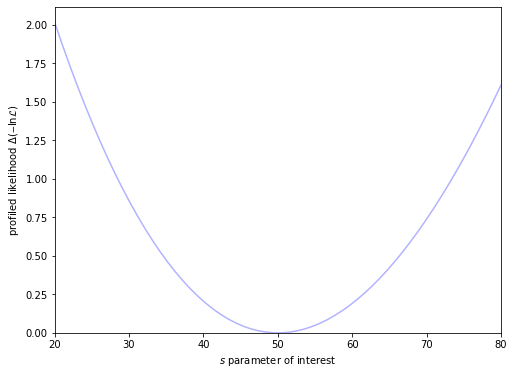

In [0]:
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
fig, ax = plt.subplots(figsize=(8,6))

shift_nll = p_nll[0]-p_nll[0].min()
inf_line = ax.plot(s_exp_scan, shift_nll ,"b",alpha=0.3)

#shift = nll[0]-nll[0].min()
#inf_line2 = ax.plot(s_exp_scan, shift ,"r",alpha=0.3)

ax.set_ylim(bottom=0)
ax.set_xlim(left=s_exp_scan.min(), right=s_exp_scan.max())

ax.set_xlabel("$s$ parameter of interest")
ax.set_ylabel(r"profiled likelihood $\Delta(\mathcal{-\ln L})$")


## Random snippets

In [0]:
# Full model
# expected amount of signal
signal_exp = tf.Variable(50., shape=(), name="signal_exp")
# expected amount of background
bkg_exp = tf.Variable(1000., shape=(), name="bkg_exp")

# compute signal fraction from s_exp and b_exp
mu = signal_exp / (signal_exp + bkg_exp)

# full mixture distribution
m_dist = ds.Mixture(cat=ds.Categorical(probs=[1. - mu, mu]),
                            components=[b_dist, s_dist],
                            name="mixture")

b_counts = tf.Variable(
[1.2013696e-02, 3.4166566e-01, 5.8940423e-01, 1.3969673e-03, 1.5554641e-02,
4.4392496e-03, 2.0298790e-03, 3.1998839e-02, 1.3944731e-03, 1.0269688e-04], dtype=tf.float32)
s_counts = tf.Variable(
[1.7830627e-02, 4.5834020e-01, 3.2262495e-01, 5.3610229e-03, 6.8719871e-02,
3.9853200e-02, 6.2792581e-03, 7.6308973e-02, 4.4561680e-03, 2.2559472e-04], dtype=tf.float32)


with tf.GradientTape(persistent = True) as g:
    
    g.watch(signal_exp)
    g.watch(bkg_exp)
    g.watch(b_counts)
    g.watch(s_counts)
    """
    with tf.GradientTape(persistent = True) as gg:
        
        gg.watch(signal_exp)
        gg.watch(bkg_exp)
        gg.watch(b_counts)
        gg.watch(s_counts)

        print(b_counts)
        print(s_counts)
    """
    exp_counts = tf.cast(signal_exp * s_counts + bkg_exp * b_counts, dtype=tf.float64)
    print( "EXPCOUNTS")
    print( exp_counts )

    asimov = tf.stop_gradient(exp_counts, name="asimov")
    print(asimov)  
    print('Sig Asimov')
    print(g.gradient(asimov, signal_exp))       

    pois = ds.Poisson(exp_counts, name="poisson")


    nll = - tf.cast(tf.reduce_sum(pois.log_prob(asimov)),
                        name="nll", dtype=tf.float32)
    #g.watch(nll)
    print('NLL Asimov')
    print(g.gradient(nll, [signal_exp, bkg_exp]))
    
    """
    dy_dx = gg.gradient(nll, [signal_exp, bkg_exp])
    dy_dx = [tf.zeros_like(pars[j]) if grad is None else grad
                      for j, grad in enumerate(dy_dx)]     

    print(dy_dx)

    batch_hessian = hessian(g, dy_dx, [signal_exp, bkg_exp])

    print('hessian Asimov')
    print(g.gradient(batch_hessian[0,0], asimov))
    
    print('Batch hessian')
    print(batch_hessian)

    cov = tf.linalg.inv(batch_hessian)

    print('cov')
    #exp_counts = loss
    #print(tf.matmul(cov, batch_hessian))
    """

#g.gradient(nll, pars)

In [0]:
vals = []
probs = []
for i in range(1000):
    x = tf.random.uniform(shape=[10,], minval=0, maxval=100, dtype=tf.float64)
    vals.append( x.numpy( ))
    probs.append( pois.log_prob(x).numpy() )

In [0]:
vals = np.array(vals)
probs = np.array(probs)

In [0]:
probs.shape

In [0]:
plt.scatter(vals[:,0], probs[:,0])

In [0]:
pois.log_prob(exp_counts).numpy()

In [0]:
v = tf.Variable(tf.random.normal((2,)))
print(v)
with tf.GradientTape(persistent=True) as tape:
    y = tf.sin(v[0] + tf.cos(v[1]))
    print([v])
    grads = tape.gradient(y, [v])
    #print( grads )
    print( grads[0] )
    #print( tape.gradient(y, v) )
    #print
hessians = tape.jacobian(grads[0], v)
#hessians = tape.gradient(grads[0], [v])
print(hessians)

In [0]:
x = tf.random.uniform(shape=[3,2],minval=0, maxval=10) 
y = tf.random.uniform(shape=[3,4],minval=0, maxval=10) 
w1 = tf.Variable(tf.ones([2,3]),dtype=tf.float32 )
w2 = tf.Variable(tf.ones([3,3]), dtype=tf.float32)
w3 = tf.Variable(tf.ones([3,4]), dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam()

with tf.GradientTape() as g:
    
    #g.watch(w1)
    #g.watch(w2)
    #hidden = tf.stop_gradient(tf.matmul(x,w1))
    hidden = tf.matmul(x,w1)
    print(hidden)
    hidden2 = tf.matmul(hidden, w2)
    asimov = tf.stop_gradient(hidden2)
    print(hidden2)
    print(asimov)
    output = tf.matmul(hidden2,w3)
    print(output)
    loss = output - y
    print(loss)

gradients = g.gradient(loss, [w1,w2,w3])
print(gradients)
optimizer.apply_gradients(zip(gradients, [w1,w2,w3])) 
print(w1)
print(w2)
print(w3)